# Neural Networks

In [1]:
from numpy.random import seed
seed(1)

In [2]:
import pandas as pd
import numpy as np
import time
import pickle
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from tensorflow import keras
from tensorflow.keras.regularizers import l2

import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.metrics import f1_score, plot_confusion_matrix, confusion_matrix
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbPipeline
from imblearn.over_sampling import SMOTE

from category_encoders import TargetEncoder

import warnings
warnings.filterwarnings('ignore')

/Applications/anaconda3/envs/learn-env/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [3]:
X_train = pd.read_csv('Data/X_train.csv', index_col='building_id')
X_test = pd.read_csv('Data/X_test.csv', index_col='building_id')
y_train = pd.read_csv('Data/y_train.csv', index_col='building_id')
y_test = pd.read_csv('Data/y_test.csv', index_col='building_id')

### Further split X_train and y_train to create validation sets for the Keras model

In [4]:
X_pure_train, X_val, y_pure_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=.2)

### Divide the columns and define columns to drop

As before, we will drop unimportant columns. 

In [5]:
binary_cols = []
for col in X_train.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(X_train.select_dtypes(include='object').columns)

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [6]:
binary_cols_dropped = binary_cols.copy()
for col in binary_cols_dropped:
    if col.startswith('has_secondary'):
        binary_cols_dropped.remove(col)
binary_cols_dropped.append('has_secondary_use')

cat_cols_dropped = cat_cols.copy()
cat_cols_dropped.remove('legal_ownership_status')
cat_cols_dropped.remove('plan_configuration')

### Create the Column Transformer

We will log transform and scale integer columns, OHE categorical columns, and target endcode the geographical columns.

In [7]:
#Small function for the integer columns
def log_transform(x):
    return np.log(x+1)

In [8]:
function_transformer = FunctionTransformer(log_transform)

ohe_pipe = imbPipeline([('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
integer_pipe = imbPipeline([
    ('function', function_transformer),
    ('ss', StandardScaler())
])
target_pipe = imbPipeline([('target', TargetEncoder(cols=geo_cols))])

transformer = ColumnTransformer([
    ('binary', 'passthrough', binary_cols_dropped),
    ('categorical', ohe_pipe, cat_cols_dropped),
    ('geo', target_pipe, geo_cols),
    ('integer', integer_pipe, integer_cols),
])

In [9]:
#Fit_transform X_pure_train and y_pure_train; transform X_val and X_test (for later scoring the test set)
X_pure_train = transformer.fit_transform(X_pure_train, y_pure_train)
X_val = transformer.transform(X_val)
X_test = transformer.transform(X_test)

### Pickle the Column Transformer

In [10]:
#with open ('../Models/keras_transformer.pickle', 'wb') as f:
#    pickle.dump(transformer, f, pickle.HIGHEST_PROTOCOL)

### OHE the target for use in the Keras model

In [11]:
ohe = OneHotEncoder(sparse=False)
y_pure_train_ohe = ohe.fit_transform(y_pure_train.values)
y_val_ohe = ohe.transform(y_val.values)

### keras0:  Build a simple neural network

In [12]:
#Create an EarlyStopping object that monitors 'val_f1_score' for a maximum, with a patience of five epochs.
early_stop = EarlyStopping(monitor='val_f1_score', mode='max', patience=5, verbose=1)

In [13]:
#Use the tensorflow add-on F1Score to create a micro averaged f1 score metric for the model
metric = tfa.metrics.F1Score(num_classes=3, average='micro')

In [14]:
keras0 = Sequential()
keras0.add(Dense(16, input_dim=X_pure_train.shape[1], activation='relu'))
keras0.add(Dense(8, activation='relu'))
keras0.add(Dense(3, activation='softmax'))

keras0.compile(loss='categorical_crossentropy', optimizer='adam', 
               metrics=metric)

In [15]:
results = keras0.fit(X_pure_train, y_pure_train_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 1s 3ms/step - loss: 0.8473 - f1_score: 0.5794 - val_loss: 0.7432 - val_f1_score: 0.6758
Epoch 2/50
157/157 [==============================] - 0s 2ms/step - loss: 0.6689 - f1_score: 0.7136 - val_loss: 0.6462 - val_f1_score: 0.7180
Epoch 3/50
157/157 [==============================] - 0s 2ms/step - loss: 0.6027 - f1_score: 0.7351 - val_loss: 0.6267 - val_f1_score: 0.7271
Epoch 4/50
157/157 [==============================] - 0s 1ms/step - loss: 0.5845 - f1_score: 0.7429 - val_loss: 0.6244 - val_f1_score: 0.7298
Epoch 5/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5788 - f1_score: 0.7448 - val_loss: 0.6224 - val_f1_score: 0.7302
Epoch 6/50
157/157 [==============================] - 0s 1ms/step - loss: 0.5756 - f1_score: 0.7470 - val_loss: 0.6234 - val_f1_score: 0.7306
Epoch 7/50
157/157 [==============================] - 0s 1ms/step - loss: 0.5737 - f1_score: 0.7472 - val_loss: 0.6220 - val_f1_score: 0.7284
Epoch 

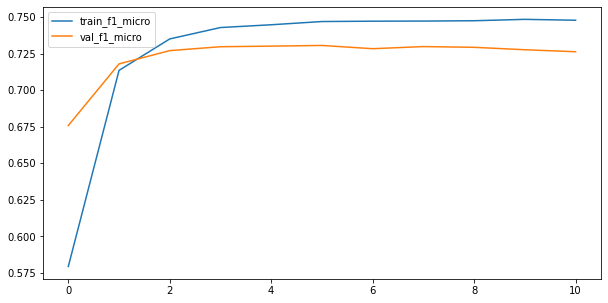

In [16]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [17]:
keras0_f1_micro = np.max(val_f1_micro)
keras0_f1_micro

0.7306216359138489

This is a baseline score, in the ballpark of our other models, though less than Random Forest, XGBoost, and SVM. It's also worth noting that the models validated f1-micro score level out after only two or three epochs.

### keras1: Add more layers to the neural network

In [18]:
keras1 = Sequential()
keras1.add(Dense(64, input_dim=X_pure_train.shape[1], activation='relu'))
keras1.add(Dense(32, activation='relu'))
keras1.add(Dense(16, activation='relu'))
keras1.add(Dense(8, activation='relu'))
keras1.add(Dense(3, activation='softmax'))

keras1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metric)

In [19]:
results = keras1.fit(X_pure_train, y_pure_train_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 1s 6ms/step - loss: 0.7722 - f1_score: 0.6633 - val_loss: 0.6380 - val_f1_score: 0.7228
Epoch 2/50
157/157 [==============================] - 0s 3ms/step - loss: 0.5862 - f1_score: 0.7415 - val_loss: 0.6297 - val_f1_score: 0.7268
Epoch 3/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5736 - f1_score: 0.7471 - val_loss: 0.6242 - val_f1_score: 0.7254
Epoch 4/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5687 - f1_score: 0.7488 - val_loss: 0.6174 - val_f1_score: 0.7292
Epoch 5/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5681 - f1_score: 0.7483 - val_loss: 0.6190 - val_f1_score: 0.7287
Epoch 6/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5654 - f1_score: 0.7498 - val_loss: 0.6191 - val_f1_score: 0.7282
Epoch 7/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5643 - f1_score: 0.7499 - val_loss: 0.6192 - val_f1_score: 0.7296
Epoch 

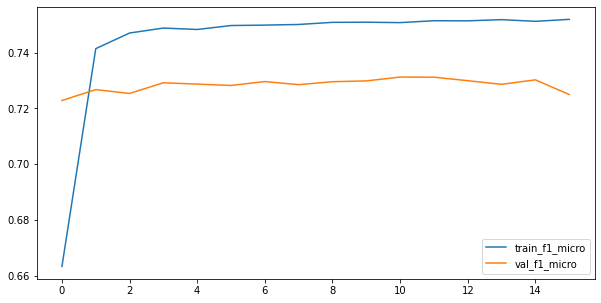

In [20]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [21]:
keras1_f1_micro = np.max(val_f1_micro)
keras1_f1_micro

0.7312611937522888

Addtional layers has improved the score slightly.  

### keras2: Add even more layers to the neural network

In [22]:
keras2 = Sequential()
keras2.add(Dense(512, input_dim=X_pure_train.shape[1], activation='relu'))
keras2.add(Dense(256, activation='relu'))
keras2.add(Dense(128, activation='relu'))
keras2.add(Dense(64, activation='relu'))
keras2.add(Dense(32, activation='relu'))
keras2.add(Dense(16, activation='relu'))
keras2.add(Dense(8, activation='relu'))
keras2.add(Dense(3, activation='softmax'))

keras2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metric)

In [23]:
results = keras2.fit(X_pure_train, y_pure_train_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 2s 14ms/step - loss: 0.6474 - f1_score: 0.7115 - val_loss: 0.6224 - val_f1_score: 0.7215
Epoch 2/50
157/157 [==============================] - 2s 14ms/step - loss: 0.5739 - f1_score: 0.7448 - val_loss: 0.6455 - val_f1_score: 0.7075
Epoch 3/50
157/157 [==============================] - 2s 14ms/step - loss: 0.5689 - f1_score: 0.7471 - val_loss: 0.6139 - val_f1_score: 0.7290
Epoch 4/50
157/157 [==============================] - 3s 16ms/step - loss: 0.5645 - f1_score: 0.7480 - val_loss: 0.6141 - val_f1_score: 0.7308
Epoch 5/50
157/157 [==============================] - 3s 16ms/step - loss: 0.5579 - f1_score: 0.7511 - val_loss: 0.6149 - val_f1_score: 0.7291
Epoch 6/50
157/157 [==============================] - 4s 25ms/step - loss: 0.5571 - f1_score: 0.7510 - val_loss: 0.6205 - val_f1_score: 0.7296
Epoch 7/50
157/157 [==============================] - 2s 14ms/step - loss: 0.5571 - f1_score: 0.7514 - val_loss: 0.6190 - val_f1_score: 0.7271

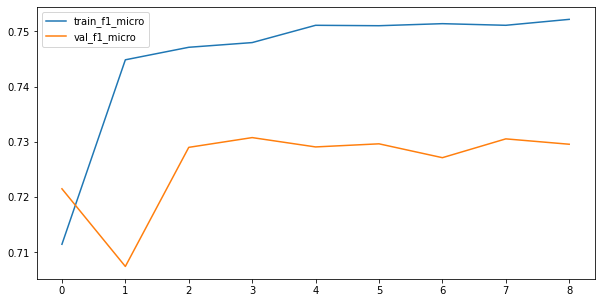

In [24]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [25]:
keras2_f1_micro = np.max(val_f1_micro)
keras2_f1_micro

0.7307751178741455

The addional complexity decreases the score marginally.  Let's consider keras1 the better model, especially due to its relative simplicity.

### keras3:  Try using SMOTE

First, I'll resample X_pure_train (to which the Column Transformer was already applied) and y_pure train using SMOTE. Then I'll OHE the new resampled y_pure_train in addition to transforming y_val again with the fitted OHE. I'll use the model structure of keras1, since it's a simpler model than keras2, but produced a similar validated f1-micro score. 

In [26]:
smote = SMOTE()
X_pure_train_resampled, y_pure_train_resampled = smote.fit_sample(X_pure_train, y_pure_train)

In [27]:
ohe = OneHotEncoder(sparse=False)
y_pure_train_resampled_ohe = ohe.fit_transform(y_pure_train_resampled.values)
y_val_ohe = ohe.transform(y_val.values)

In [28]:
keras3 = Sequential()
keras3.add(Dense(64, input_dim=X_pure_train_resampled.shape[1], activation='relu'))
keras3.add(Dense(32, activation='relu'))
keras3.add(Dense(16, activation='relu'))
keras3.add(Dense(8, activation='relu'))
keras3.add(Dense(3, activation='softmax'))

keras3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metric)

In [29]:
results = keras3.fit(X_pure_train_resampled, y_pure_train_resampled_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
267/267 [==============================] - 1s 3ms/step - loss: 0.6569 - f1_score: 0.7073 - val_loss: 0.7346 - val_f1_score: 0.6794
Epoch 2/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5635 - f1_score: 0.7585 - val_loss: 0.7043 - val_f1_score: 0.6864
Epoch 3/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5573 - f1_score: 0.7610 - val_loss: 0.7224 - val_f1_score: 0.6743
Epoch 4/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5538 - f1_score: 0.7629 - val_loss: 0.7285 - val_f1_score: 0.6704
Epoch 5/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5506 - f1_score: 0.7643 - val_loss: 0.7164 - val_f1_score: 0.6774
Epoch 6/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5478 - f1_score: 0.7651 - val_loss: 0.6946 - val_f1_score: 0.6888
Epoch 7/50
267/267 [==============================] - 1s 2ms/step - loss: 0.5462 - f1_score: 0.7662 - val_loss: 0.6950 - val_f1_score: 0.6868
Epoch 

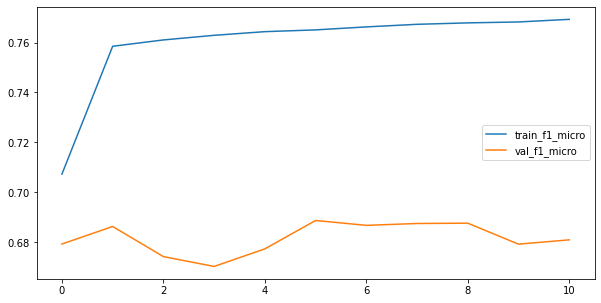

In [30]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [31]:
keras3_f1_micro = np.max(val_f1_micro)
keras3_f1_micro

0.688769519329071

Using SMOTE results in an inferior validated f1-micro score.  Keras1 is still the best model.

### keras4:  Try using regularization

Again, we will use keras1 as the baseline and then add some regularization to the layers.

In [32]:
keras4 = Sequential()
keras4.add(Dense(64, input_dim=X_pure_train.shape[1], activation='relu'))
keras4.add(Dense(32, activation='relu', kernel_regularizer=l2(l2=.001)))
keras4.add(Dense(16, activation='relu', kernel_regularizer=l2(l2=.001)))
keras4.add(Dense(8, activation='relu', kernel_regularizer=l2(l2=.001)))
keras4.add(Dense(3, activation='softmax'))

keras4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=metric)

In [33]:
results = keras4.fit(X_pure_train, y_pure_train_ohe, epochs=50, batch_size=1000, 
                     validation_data=(X_val, y_val_ohe), callbacks=[early_stop])

Epoch 1/50
157/157 [==============================] - 1s 3ms/step - loss: 0.7878 - f1_score: 0.6466 - val_loss: 0.6718 - val_f1_score: 0.7290
Epoch 2/50
157/157 [==============================] - 0s 2ms/step - loss: 0.6212 - f1_score: 0.7428 - val_loss: 0.6652 - val_f1_score: 0.7256
Epoch 3/50
157/157 [==============================] - 0s 2ms/step - loss: 0.6078 - f1_score: 0.7465 - val_loss: 0.6506 - val_f1_score: 0.7301
Epoch 4/50
157/157 [==============================] - 0s 2ms/step - loss: 0.6007 - f1_score: 0.7479 - val_loss: 0.6467 - val_f1_score: 0.7275
Epoch 5/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5967 - f1_score: 0.7481 - val_loss: 0.6436 - val_f1_score: 0.7282
Epoch 6/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5946 - f1_score: 0.7479 - val_loss: 0.6458 - val_f1_score: 0.7275
Epoch 7/50
157/157 [==============================] - 0s 2ms/step - loss: 0.5922 - f1_score: 0.7483 - val_loss: 0.6493 - val_f1_score: 0.7248
Epoch 

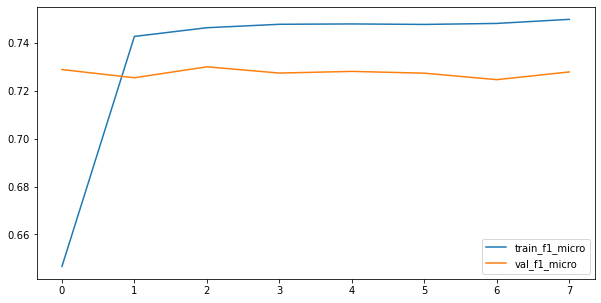

In [34]:
train_f1_micro = results.history['f1_score']
val_f1_micro = results.history['val_f1_score']

fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x=results.epoch, y=train_f1_micro, ax=ax, label='train_f1_micro')
sns.lineplot(x=results.epoch, y=val_f1_micro, ax=ax, label='val_f1_micro');

In [35]:
keras4_f1_micro = np.max(val_f1_micro)
keras4_f1_micro

0.7301355600357056

Regularization reduces the f1-micro score slightly, though it is close to keras1.  We'll finish here and say that keras1 is the best model.

In [36]:
print(f'keras0_f1_micro: {round(keras0_f1_micro, 4)}')
print(f'keras1_f1_micro: {round(keras1_f1_micro, 4)}')
print(f'keras2_f1_micro: {round(keras2_f1_micro, 4)}')
print(f'keras3_f1_micro: {round(keras3_f1_micro, 4)}')
print(f'keras4_f1_micro: {round(keras4_f1_micro, 4)}')

keras0_f1_micro: 0.7306
keras1_f1_micro: 0.7313
keras2_f1_micro: 0.7308
keras3_f1_micro: 0.6888
keras4_f1_micro: 0.7301


### Make predictions on the test set using keras1 and calculate the f1-micro score

In [37]:
y_hat_test = np.argmax(keras1.predict(X_test), axis=-1)

In [38]:
f1_score(y_test, y_hat_test + 1, average='micro')

0.7258522509247748

The final test f1-micro score is in the ballpark of our other models, though Random Forest, XGBoost, SVM, and even Logistic Regression perform slightly better.

### Check model's target accuracies

In [39]:
cm = confusion_matrix(y_test, y_hat_test + 1)
low_damage = cm[0][0] / (cm[0][0] + cm[0][1] + cm[0][2])
medium_damage = cm[1][1] / (cm[1][0] + cm[1][1] + cm[1][2])
complete_destruction = cm[2][2] / (cm[2][0] + cm[2][1] + cm[2][2])
print(f'The model correctly predicts {round(low_damage*100, 2)}% of low damage.')
print(f'The model correctly predicts {round(medium_damage*100, 2)}% of medium damage.')
print(f'The model correctly predicts {round(complete_destruction*100, 2)}% of complete destruction.')

The model correctly predicts 50.72% of low damage.
The model correctly predicts 79.02% of medium damage.
The model correctly predicts 67.95% of complete destruction.


### Export the model

In [40]:
#keras1.save('../Models/keras1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../Models/keras1/assets
